In [1]:
# Load libraries
import pandas as pd
import numpy as np

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

# Model building
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Evaluation metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, plot_roc_curve, roc_auc_score

# Save model
import pickle

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

wn = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maryy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data
traindf = pd.read_csv('data/twitter_training.csv', header=None)
testdf = pd.read_csv('data/twitter_validation.csv', header=None)

In [3]:
#shape of data
print('Train data shape: ',traindf.shape) 
print('Test data shape: ',testdf.shape)

Train data shape:  (74682, 4)
Test data shape:  (1000, 4)


In [4]:
traindf.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
testdf.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


Both train and test have the same columns. We will create a function to rename the columns. This will allow greater readability of the data. 

In [6]:
# Rename columns
def rename_columns(df):
    df.rename(columns= {0:'Tweet_ID',1:'Topic',2:'Sentiment',3:'Tweet'},inplace=True)

In [7]:
# Rename columns for traindf
rename_columns(traindf)
traindf.head()

,Tweet_ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
# Rename columns for testdf
rename_columns(testdf)
testdf.head()

,Tweet_ID,Topic,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [9]:
# Check Null values, traindf
null_stats = pd.DataFrame(traindf.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/traindf.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset
Tweet,686,0.92


The missing values only account for 0.92% of the data, so we will drop them. 

In [10]:
# Drop null values
traindf.dropna(axis=0,inplace=True)

In [11]:
# Check Null values, traindf
null_stats = pd.DataFrame(traindf.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/traindf.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset


In [12]:
# Check Null values, testdf
null_stats = pd.DataFrame(testdf.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/testdf.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset


No missing values in the test data.

In [13]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   73996 non-null  int64 
 1   Topic      73996 non-null  object
 2   Sentiment  73996 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [14]:
print('Distinct Values: \n')
col=['Topic','Sentiment']
for i in col:
    print(i,'---------')
    print(traindf[i].value_counts())
    print('\n')

Distinct Values: 

Topic ---------
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283

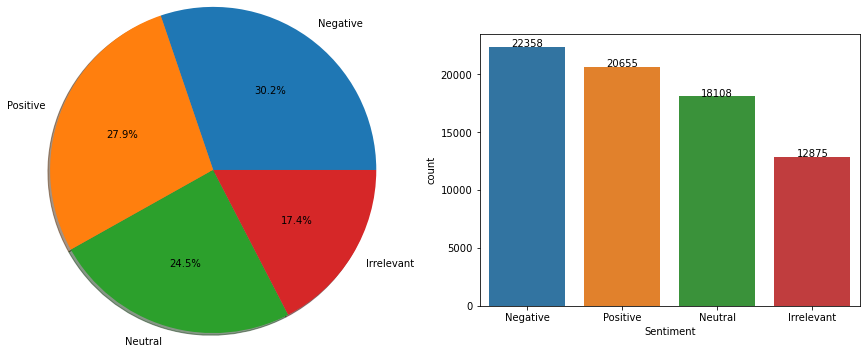

In [15]:
# Visualising sentiment feature 
plt.figure(figsize=(15,5))

#plot pie chart
plt.subplot(1,2,1)
label = traindf['Sentiment'].value_counts().index
label_count = traindf['Sentiment'].value_counts().values
plt.pie(data=traindf, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

#plot countplot
plt.subplot(1,2,2)
ax = sns.countplot(x='Sentiment', data=traindf, order=label)
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),
    y=height+0.2,ha='center',s='{:.0f}'.format(height))
plt.show()

Data is observe to be balanced. Texts in Tweet column will be preprocessed. 

In [16]:
# make a dictionary of contractions
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [17]:
# preprocessing
def clean_text(text):
    # convert to lower case
    text = text.lower()
    #remove user handle
    text = re.sub("@[\w]*", '', text)
    #remove http links
    text = re.sub("http\S+", '', text)
    #remove digits and spl characters
    text = re.sub("[^a-zA-Z#]", ' ', text)
    #remove contractions
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])
    #tokenize text
    tokens = re.split('\W+', text)
    #remove stopwords
    text = ' '.join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    # remove hashtag
    text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    #remove rt characters
    text = re.sub("rt", '', text)
    #remove additional spaces
    text = re.sub("\s+", ' ', text)
    
    return text

In [18]:
traindf['Clean_Tweet'] = traindf['Tweet'].apply(clean_text)

In [19]:
traindf

,Tweet_ID,Topic,Sentiment,Tweet,Clean_Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realized window paition mac like year behind n...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realized mac window paition year behind nvidia...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realized window paition mac year behind nvidia...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,realized window paition mac like year behind n...


Modelling

In [20]:
# Establish X and y
X= traindf['Clean_Tweet']
y= traindf['Sentiment']

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=10)

By using pipelines it would help automate and streamline the modelling process. Fed into the pipelines are the vectorizers and the classifiers to help train our models. By creating different vectorizer and classifier combinations, this allows for a choice of the best model combination. 

Vectorizers:
- CountVectorizer
- TF-IDF

Classifiers:
- Bernoulli Naive Bayes
- Multinomial Naive Bayes
- Random Forest

In [44]:
#baseline model
# Instantiate a TFIDF + LogisticRegression
baseline = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('logR', LogisticRegression())])

# Fit
baseline.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', baseline.score(X_test, y_test))

Model Score:  0.7481868552637506


In [21]:
# pipe
# Instantiate a CountVectorizer + BernoulliNB
pipe = Pipeline([('count', CountVectorizer(analyzer = 'word')),
                ('Bern', BernoulliNB(binarize=True))])

# Fit
pipe.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe.score(X_test, y_test))

Model Score:  0.3872246497589982


In [22]:
# pipe2
# Instantiate a CountVectorizer + MultinomialNB
pipe2 = Pipeline([('count', CountVectorizer(analyzer = 'word')),
                ('Multi', MultinomialNB())])

# Fit 
pipe2.fit(X_train, y_train);


# Evalute best model
print('Model Score: ', pipe2.score(X_test, y_test))

Model Score:  0.7283210955448444


In [23]:
# pipe3
# Instantiate a CountVectorizer + RandomForestClassifier
pipe3 = Pipeline([('count', CountVectorizer(analyzer = 'word')),
                ('rforest', RandomForestClassifier(n_estimators=200, random_state= 10))])

# Fit
pipe3.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe3.score(X_test, y_test))

Model Score:  0.8973377179152214


In [24]:
# pipe4
# Instantiate a TF-IDF + BernoulliNB
pipe4 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('Bern', BernoulliNB(binarize=True))])

# Fit 
pipe4.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe4.score(X_test, y_test))

Model Score:  0.30271633857380964


In [25]:
# pipe5
# Instantiate a TF-IDF + MultinomialNB
pipe5 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('Multi', MultinomialNB())])

# Fit 
pipe5.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe5.score(X_test, y_test))

Model Score:  0.7102572187936393


In [26]:
# pipe6
# Instantiate a TF-IDF + RandomForestClassifier
pipe6 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                ('rforest', RandomForestClassifier(n_estimators=200, random_state= 10))])

# Fit 
pipe6.fit(X_train, y_train);

# Evalute best model
print('Model Score: ', pipe6.score(X_test, y_test))

Model Score:  0.9013018604441642


PIPELINES WITH GRIDSEARCHCV

In [27]:
# Parameters tuning for pipe
pipe.get_params()

{'memory': None,
 'steps': [('count', CountVectorizer()), ('Bern', BernoulliNB(binarize=True))],
 'verbose': False,
 'count': CountVectorizer(),
 'Bern': BernoulliNB(binarize=True),
 'count__analyzer': 'word',
 'count__binary': False,
 'count__decode_error': 'strict',
 'count__dtype': numpy.int64,
 'count__encoding': 'utf-8',
 'count__input': 'content',
 'count__lowercase': True,
 'count__max_df': 1.0,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 1),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'Bern__alpha': 1.0,
 'Bern__binarize': True,
 'Bern__class_prior': None,
 'Bern__fit_prior': True}

In [28]:
# Hyperparametertuning for pipe
pipe = Pipeline([('count', CountVectorizer()),
                ('Bern', BernoulliNB())])

# Define dictionary hyperparameters
pipe_params = {'count__analyzer': ['word', 'char', 'char_wb'],
               'count__max_df': [0.0, 0.5, 1.0], 
               'count__min_df': [0.0, 1.0],
               'count__ngram_range': [(1,1), (1,2), (1,3)],
               'Bern__alpha' : [0, 1]} 

# Instantiate GridSearchCV
pipe_grid = GridSearchCV(pipe,pipe_params, cv=5, verbose=2, n_jobs= -1)

# Fit the gridsearch object to data
pipe_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe_grid.score(X_test, y_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Score:  0.896190908545383
Best Estimator:  Pipeline(steps=[('count',
                 CountVectorizer(max_df=0.5, min_df=0.0, ngram_range=(1, 2))),
                ('Bern', BernoulliNB(alpha=0))])
Model Score:  0.9047704851569891


In [29]:
pipe2.get_params()

{'memory': None,
 'steps': [('count', CountVectorizer()), ('Multi', MultinomialNB())],
 'verbose': False,
 'count': CountVectorizer(),
 'Multi': MultinomialNB(),
 'count__analyzer': 'word',
 'count__binary': False,
 'count__decode_error': 'strict',
 'count__dtype': numpy.int64,
 'count__encoding': 'utf-8',
 'count__input': 'content',
 'count__lowercase': True,
 'count__max_df': 1.0,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 1),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'Multi__alpha': 1.0,
 'Multi__class_prior': None,
 'Multi__fit_prior': True}

In [30]:
# Hyperparametertuning for pipe
pipe2 = Pipeline([('count', CountVectorizer()),
                ('Multi', MultinomialNB())])

# Define dictionary hyperparameters
pipe2_params = {'count__analyzer': ['word', 'char', 'char_wb'],
               'count__max_df': [0.0, 0.5, 1.0], 
               'count__min_df': [0.0, 1.0],
               'count__ngram_range': [(1,1), (1,2), (1,3)],
               'Multi__alpha' : [0, 0.2, 0.5, 0.75, 1]} 

# Instantiate GridSearchCV
pipe2_grid = GridSearchCV(pipe2,pipe2_params, cv=5, verbose=2, n_jobs= -1)

# Fit the gridsearch object to data
pipe2_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe2_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe2_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe2_grid.score(X_test, y_test))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Score:  0.9078131786993646
Best Estimator:  Pipeline(steps=[('count',
                 CountVectorizer(max_df=0.5, min_df=0.0, ngram_range=(1, 3))),
                ('Multi', MultinomialNB(alpha=0))])
Model Score:  0.9139600882922654


In [31]:
pipe3.get_params()

{'memory': None,
 'steps': [('count', CountVectorizer()),
  ('rforest', RandomForestClassifier(n_estimators=200, random_state=10))],
 'verbose': False,
 'count': CountVectorizer(),
 'rforest': RandomForestClassifier(n_estimators=200, random_state=10),
 'count__analyzer': 'word',
 'count__binary': False,
 'count__decode_error': 'strict',
 'count__dtype': numpy.int64,
 'count__encoding': 'utf-8',
 'count__input': 'content',
 'count__lowercase': True,
 'count__max_df': 1.0,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 1),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rforest__bootstrap': True,
 'rforest__ccp_alpha': 0.0,
 'rforest__class_weight': None,
 'rforest__criterion': 'gini',
 'rforest__max_depth': None,
 'rforest__max_features': 'auto',
 'rforest__max_leaf_nodes': None,
 'rforest__max_samples': None,
 'rf

In [34]:
# Hyperparametertuning for pipe
pipe3 = Pipeline([('count', CountVectorizer()),
                ('rforest', RandomForestClassifier(random_state = 10))])

# Define dictionary hyperparameters
pipe3_params = {'count__analyzer': ['word', 'char', 'char_wb'],
               'count__max_df': [0.5, 1.0], 
               'count__min_df': [0.0, 1.0],
               'count__ngram_range': [(1,1), (1,2), (1,3)],
               'rforest__n_estimators':[200, 500],
               'rforest__max_depth': [10, 15],
               'rforest__min_samples_leaf': [5, 10],
               'rforest__min_samples_split': [5, 10]} 


# Instantiate GridSearchCV
pipe3_grid = GridSearchCV(pipe3,pipe3_params, cv=5, verbose=2, n_jobs = -1)

# Fit the gridsearch object to data
pipe3_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe3_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe3_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe3_grid.score(X_test, y_test))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Score:  0.602390197694281
Best Estimator:  Pipeline(steps=[('count',
                 CountVectorizer(analyzer='char_wb', min_df=0.0,
                                 ngram_range=(1, 2))),
                ('rforest',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=10))])
Model Score:  0.618135952069913


In [35]:
pipe4.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('Bern', BernoulliNB(binarize=True))],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'Bern': BernoulliNB(binarize=True),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'Bern__alpha': 1.0,
 'Bern__binarize': True,
 'Bern__class_prior': None,
 'Bern__fit_prior': True}

In [36]:
# Hyperparametertuning for pipe
pipe4 = Pipeline([('tfidf', TfidfVectorizer()),
                ('Bern', BernoulliNB())])

# Define dictionary hyperparameters
pipe4_params = {'tfidf__analyzer': ['word', 'char', 'char_wb'],
               'tfidf__max_df': [0.0, 0.5, 1.0], 
               'tfidf__min_df': [0.0, 1.0],
               'Bern__alpha' : [0, 1]} 

# Instantiate GridSearchCV
pipe4_grid = GridSearchCV(pipe4,pipe4_params, cv=5, verbose=2, n_jobs = -1)

# Fit the gridsearch object to data
pipe4_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe4_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe4_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe4_grid.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score:  0.7724193499693065
Best Estimator:  Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, min_df=0.0)),
                ('Bern', BernoulliNB(alpha=0))])
Model Score:  0.7768367944502005


In [37]:
# Hyperparametertuning for pipe
pipe5 = Pipeline([('tfidf', TfidfVectorizer()),
                ('Multi', MultinomialNB())])

# Define dictionary hyperparameters
pipe5_params = {'tfidf__analyzer': ['word', 'char', 'char_wb'],
               'tfidf__max_df': [0.0, 0.5, 1.0], 
               'tfidf__min_df': [0.0, 1.0],
               'Multi__alpha' : [0, 0.2, 0.5, 0.75, 1]} 

# Instantiate GridSearchCV
pipe5_grid = GridSearchCV(pipe5,pipe5_params, cv=5, verbose=1)

# Fit the gridsearch object to data
pipe5_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe5_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe5_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe5_grid.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Score:  0.7869760613287979
Best Estimator:  Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5, min_df=0.0)),
                ('Multi', MultinomialNB(alpha=0))])
Model Score:  0.7920176584530835


In [38]:
# Hyperparametertuning for pipe
pipe6 = Pipeline([('tfidf', TfidfVectorizer()),
                ('rforest', RandomForestClassifier(random_state = 10))])

# Define dictionary hyperparameters
pipe6_params = {'tfidf__analyzer': ['word', 'char', 'char_wb'],
               'tfidf__max_df': [0.5, 1.0], 
               'tfidf__min_df': [0.0, 1.0],
               'rforest__n_estimators':[200, 500],
               'rforest__max_depth': [10, 15],
               'rforest__min_samples_leaf': [5, 10],
               'rforest__min_samples_split': [5, 10]} 

# Instantiate GridSearchCV
pipe6_grid = GridSearchCV(pipe6,pipe6_params, cv=5, verbose=1)

# Fit the gridsearch object to data
pipe6_grid.fit(X_train, y_train);

# Score
print('Best Score: ', pipe6_grid.best_score_)

# Best estimator
print('Best Estimator: ', pipe6_grid.best_estimator_)

# Evalute best model
print('Model Score: ', pipe6_grid.score(X_test, y_test))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score:  0.5420006254237357
Best Estimator:  Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', min_df=0.0)),
                ('rforest',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=10))])
Model Score:  0.5540339654939411


In [39]:
pred = pipe2_grid.predict(X_test)

In [40]:
# Display classfication metrics
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3404  198   69  166]
 [ 117 6340  112  151]
 [  67  286 4931  175]
 [  96  351  122 5614]]
              precision    recall  f1-score   support

  Irrelevant       0.92      0.89      0.91      3837
    Negative       0.88      0.94      0.91      6720
     Neutral       0.94      0.90      0.92      5459
    Positive       0.92      0.91      0.91      6183

    accuracy                           0.91     22199
   macro avg       0.92      0.91      0.91     22199
weighted avg       0.91      0.91      0.91     22199



In [41]:
# Save model
pickle.dump(pipe2_grid, open('model.pkl', 'wb'))